# 2. Data exploration & Baseline model generation


In the previous notebook, two types of data were loaded to a Postgis database called 'carto':
<br>
<br>

    * the NY census block geometries (geometries assigned with Polygon datatype)
    * NY taxi trip from Jan,Apr,Jul 2015(geometry data types not yet assigned)

<br>

Current schema of the baseline is as shown in the below diagram.

![](./tables.png)

<br>

The two tasks given for this notebook are:

1. Merge the taxi and ACS dataset by block group to compute the average number of pickups by block group

2. Train a baseline model (nothing too fancy) using as covariates the ACS variables.

<br>


As to answer these questions, I will explore the data together with the ACS dataset in following order:

1. NY taxi pickup points will be queried to be assigned with a geometry column and to be sampled (30,000 rows).
 
2. Three GeoDataFrames will be created: pickup points, census blocks, ACS data
    
3. Total number of pickups within each census block will be counted and used as a target of our baseline model.

4. ACS data will be examined and cleaned as features for our modeling.
   
5. A linear regression will be used as a baseline model to train the data and get the first insight on how demographic and socio-economic factors drive the number of pickups byblock group.

In [1]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import contextily as ctx
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

# 2-1. EDA

### Prepare data

Let's take pickup related variables only (pickup time, pickup point) from taxi .

A query will select pickup points from 'taxi_x' table **only if the points is within any census blocks**. The result will be limited to 20,000 rows per table to reduce the size of the result table.

In [2]:
# Function to retrieve data from postgis as gdf (geo data frame) using queries
def get_gdf(query, geom):
    # Connect to the database
    con =  psycopg2.connect(dbname='carto', user='carto', password='carto',
                            host='postgis', port='5432')

    # Save the query result as a geodataframe
    gdf = gpd.read_postgis(query, con, geom_col=geom)
    
    # Close connection
    con.close()
    return gdf

In [3]:
# Query to select 10,000 pickup data from each taxi table
# ***only if the points are within census block geometry polygons***. 
# Geometric Point will be created from longitude & latitude.

tablenames = ['taxi_jan', 'taxi_apr', 'taxi_jul']
result_list = []

# iter tablenames
for i, tablename in enumerate(tablenames):
    query = f'''
            with

                pickups as
                (
                    select
                        tpep_pickup_datetime as pickup_time,
                        ST_SetSRID(ST_MakePoint(pickup_longitude, pickup_latitude), 4326)
                        as pickup_point
                    from {tablename}
                )

            select pickups.*, census.geoid
            from pickups, census_blocks as census
            where ST_Contains(census.geometry, pickups.pickup_point)
            LIMIT 10000;
            '''
    
    # Append the query results to a list
    i = get_gdf(query, 'pickup_point')
    result_list.append(i)

# Save the query results as a geodataframe
pickup_points = gpd.GeoDataFrame(pd.concat(result_list, ignore_index=True),
                                 geometry='pickup_point',
                                 crs=4326)

print(pickup_points.shape)
pickup_points.head()

(30000, 3)


,pickup_time,pickup_point,geoid
0,2015-01-12 15:00:04,POINT (-73.95415 40.77545),360610138002
1,2015-01-12 15:00:05,POINT (-73.98494 40.76837),360610139007
2,2015-01-12 15:00:05,POINT (-73.96825 40.76257),360610114022
3,2015-01-12 15:00:05,POINT (-73.97678 40.75834),360610102001
4,2015-01-12 15:00:05,POINT (-73.95889 40.77203),360610134006


In [4]:
# General information
pickup_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   30000 non-null  datetime64[ns]
 1   pickup_point  30000 non-null  geometry      
 2   geoid         30000 non-null  object        
dtypes: datetime64[ns](1), geometry(1), object(1)
memory usage: 703.2+ KB


In [5]:
# Change the data type of 'geoid' column
# object -> numeric
pickup_points.geoid = pd.to_numeric(pickup_points.geoid)
print(pickup_points.geoid.dtype)

int64


**Note**:
* There are 30,000 records in this table without empty rows.
* The datatype for each column is well assigned.

Data from 61 days


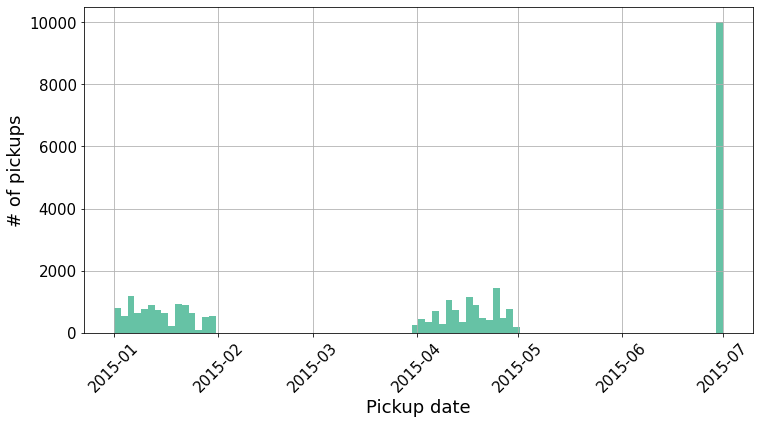

In [6]:
# Check the calendar distribution of 'pickup_time'
# by assessing its datetime.date object.
dates_from_pickup_points = pickup_points.pickup_time.dt.date

print(f'Data from {len(dates_from_pickup_points.unique())} days')

dates_from_pickup_points.hist(bins=90, figsize=(12,6))
plt.ylabel('# of pickups')
plt.xlabel('Pickup date')
plt.xticks(rotation=45)
plt.show()

**Note**:
    
* The sample data we have was collected from day 1, January to 1, July. Data from January and April was collected from all around the month, but July data was exclusively from the first day of the month.

In [7]:
# How many taxi pickups in each geoid?
n_pickups = pickup_points.groupby('geoid') \
                         .pickup_point \
                         .count() \
                         .sort_values(ascending=False)

# Result as DataFrame
n_pickups = pd.DataFrame(n_pickups)

# Rename the column name as 'n_pickups'
n_pickups = n_pickups.rename(columns={'pickup_point':'n_pickups'})

n_pickups.head()

,n_pickups
geoid,
360610101001,740
360810331001,630
360810716001,583
360610092001,462
360610099001,363


**Note:**
    
'n_pickups' from this table represents number of taxi pickups within a certain census block group ('geoid'). Therefore this 'n_pickups' column can be our target for the future baseline modeling.

[]

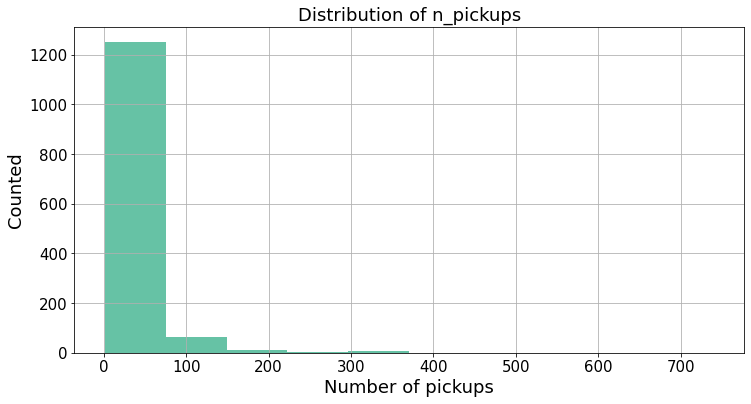

In [8]:
n_pickups.hist(figsize=(12,6))
plt.title('Distribution of n_pickups')
plt.xlabel('Number of pickups')
plt.ylabel('Counted')
plt.plot()

In [9]:
n_pickups.describe()

,n_pickups
count,1340.000000
mean,22.388060
std,50.143336
min,1.000000
25%,1.000000
50%,7.000000
75%,23.000000
max,740.000000


**Note:**
    
Averate n_pickups from the sample data is around 22 with high standard deiviation of 51.4, while the half of the data have equal to or less than 8 taxi pickups.

In [10]:
# Get top 10 pickup_points
top_10_pickups_idx = n_pickups[:10].index
top_10_pickups_idx = pd.to_numeric(top_10_pickups_idx).values
top_10_pickups_idx

array([360610101001, 360810331001, 360810716001, 360610092001,
       360610099001, 360610113001, 360610102001, 360610143001,
       360610104001, 360610094001])

# Visualize the data

A. Prepare the census block group geomteries to plot together with pickup points.

In [11]:
# Load NYC census block group geometries to draw polygons
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')

# Sanity check: Are there missing or duplicated values?
print(f'How many rows with missing values?: {census.isnull().any().sum()}')
print(f'How many duplicated rows?: {census.duplicated().sum()}')
print(f'How many blocks are there?: {len(census.geoid.unique())}')

How many rows with missing values?: 0
How many duplicated rows?: 0
How many blocks are there?: 6339


In [12]:
# Are all data types are correctly assigned?
census.dtypes

geoid         object
geometry    geometry
dtype: object

In [13]:
# Change the data type of 'geoid' column
# object -> numeric
census.geoid = pd.to_numeric(census.geoid)
print(census.geoid.dtype)

int64


B. Visualize all the pickup points on top of the census block polygons.

In [14]:
# Print the current CRS (Coordinate Reference System)
print(f'Before: {pickup_points.crs}, {census.crs}')

# Reproject data in Web mercator
pickup_points = pickup_points.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)
print(f'After: {pickup_points.crs}, {census.crs}')

Before: epsg:4326, epsg:4326
After: epsg:3857, epsg:3857


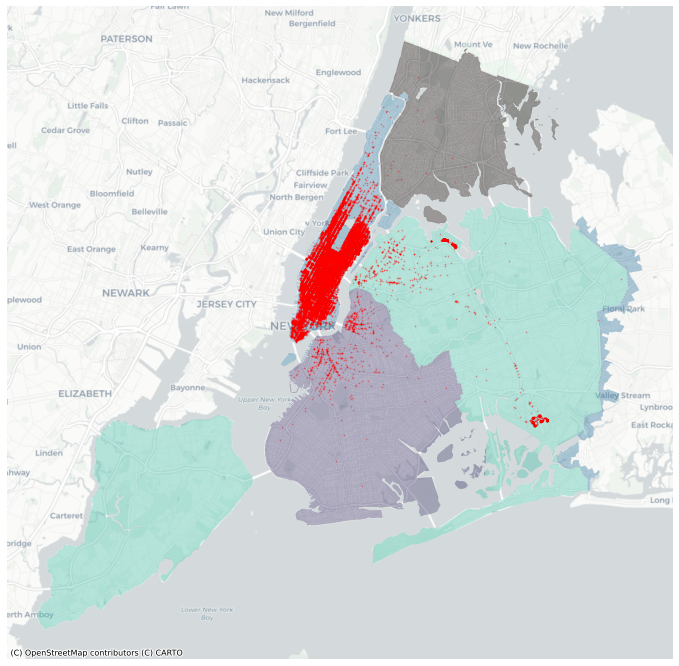

In [15]:
# Plot the census blocks (polygons)
ax = census.plot(column = 'geoid', figsize=(12, 12),
                 scheme='EqualInterval', alpha=.4, cmap='mako')

# Plot pickup points within blocks (red points)
pickup_points.plot(ax=ax, color='red', alpha=.3, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

**Note**:
* The pickup points (red points) are heavily concentrated in Manhattan area.

**Visualize the top 10 pickup points**

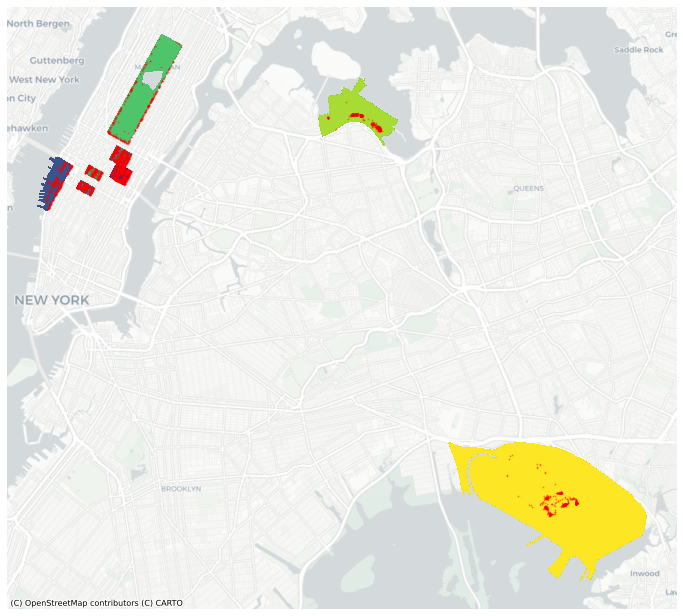

In [16]:
# Visualize census blocks with highest taxi pickups
# using geoindex of top 10 pickup points: top_10_pickups_idx

# Select top 10 points using indices
top_10_pickup_points = pickup_points.set_index('geoid') \
                                    .loc[top_10_pickups_idx]

# Plot census blocks containing top 10 pickup points (use sjoin)
ax = gpd.sjoin(census,
               top_10_pickup_points,
               how='inner',
               op='contains') \
        .plot(figsize=(12,12), cmap='viridis')

# Plot pickup points only within top 10 blocks (red points)
top_10_pickup_points.plot(ax=ax, color='red', alpha=.3, markersize=1)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

### Load more data:

Get New york's demographic & socio-economic (by census block group) dataset (.csv file). First, clean the data and then use the data to compare the top 10 pickup points with the rest of the pickup data.

In [17]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
acs = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(acs.shape)
acs.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [18]:
# Let's pivot the demographic table for convinience
acs = acs.pivot_table(values='value',
                      index='geoid',
                      columns='acs_demog_var')

print(acs.shape)
acs.head()

(6339, 33)


acs_demog_var,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,female_pop,...,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
geoid,,,,,,,,,,,,,,,,,,,,,
360050001001,NaN,25.0,125.0,3984.0,0.0,0.0,0.0,0.0,0.0,577.0,...,38.0,NaN,7080.0,NaN,7080.0,41.0,0.0,0.0,0.0,538.0
360050002001,NaN,0.0,0.0,468.0,608.0,271.0,608.0,63.0,356.0,1024.0,...,0.0,384200.0,1543.0,1793.0,1919.0,0.0,168.0,30.0,0.0,13.0
360050002002,NaN,0.0,0.0,238.0,579.0,161.0,588.0,96.0,363.0,773.0,...,86.0,415300.0,1423.0,1358.0,1703.0,0.0,118.0,71.0,15.0,52.0
360050002003,NaN,0.0,104.0,202.0,382.0,108.0,382.0,33.0,239.0,481.0,...,0.0,374700.0,718.0,1677.0,920.0,0.0,9.0,57.0,0.0,12.0
360050004001,NaN,0.0,24.0,24.0,213.0,69.0,259.0,0.0,136.0,227.0,...,0.0,363900.0,417.0,1375.0,468.0,0.0,0.0,15.0,15.0,0.0


In [19]:
# Remove if there's any empty row
acs.reset_index(inplace=True)
acs = acs[~acs.isnull()]
print(acs.shape)

(6339, 34)


In [20]:
# Remove if there's any duplicated row
acs = acs[~acs.duplicated()]
print(acs.shape)

(6339, 34)


In [21]:
# Total number of unique census blocks
len(acs.geoid.unique())

6339

In [22]:
# Are all data types are correctly assigned?
acs.dtypes

acs_demog_var
geoid                                                            int64
aggregate_travel_time_to_work                                  float64
amerindian_pop                                                 float64
asian_pop                                                      float64
black_pop                                                      float64
commuters_16_over                                              float64
commuters_by_public_transportation                             float64
employed_pop                                                   float64
families_with_young_children                                   float64
family_households                                              float64
female_pop                                                     float64
hispanic_pop                                                   float64
households                                                     float64
housing_units                                                  

**Note**:

All data types are numeric, which is good for using these fields as features of a linear regression model later. Now, Let's merge this acs data to the n_pickup data.

### Merge the n_pickups and acs data

In [23]:
# Reset index of 'n_pickups' to merge on a 'geoid' column
n_pickups.reset_index(inplace=True)

# Change the data type of 'geoid' column
# object -> numeric
n_pickups.geoid = pd.to_numeric(n_pickups.geoid)
n_pickups.geoid.dtype

dtype('int64')

In [24]:
# Merge two dataframes
df = acs.merge(n_pickups, on='geoid')
print(df.shape)
df.head()

(1340, 35)


,geoid,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickups
0,360050020002,NaN,0.0,0.0,485.0,814.0,458.0,829.0,167.0,420.0,...,430600.0,1521.0,822.0,2075.0,0.0,74.0,32.0,0.0,36.0,1
1,360050063002,NaN,0.0,0.0,167.0,207.0,137.0,207.0,0.0,50.0,...,NaN,313.0,1135.0,326.0,0.0,13.0,45.0,21.0,0.0,1
2,360050063003,NaN,0.0,26.0,97.0,258.0,174.0,250.0,88.0,122.0,...,NaN,516.0,1321.0,702.0,29.0,10.0,0.0,0.0,25.0,1
3,360050063006,NaN,0.0,16.0,399.0,801.0,572.0,822.0,159.0,521.0,...,NaN,1284.0,1227.0,1679.0,0.0,79.0,32.0,16.0,112.0,1
4,360050065004,NaN,0.0,0.0,458.0,310.0,258.0,335.0,69.0,166.0,...,NaN,678.0,1105.0,889.0,0.0,67.0,0.0,0.0,0.0,1


In [25]:
# Remove 'index' column that has been created by merge process
new_columns = [col for col in df.columns if col != 'index']
df = df[new_columns]
df.shape

(1340, 35)

In [26]:
top_10_df = df.set_index('geoid').loc[top_10_pickups_idx]
top_10_df.describe()

,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,female_pop,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickups
count,3.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,5.000000e+00,10.000000,7.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,50386.666667,2.300000,219.800000,48.400000,667.300000,293.800000,730.500000,30.900000,149.300000,450.200000,...,9.359400e+05,924.200000,3086.571429,982.000000,22.200000,34.600000,169.800000,24.700000,588.200000,439.900000
std,56242.757830,7.273239,362.331585,100.408278,1271.918153,545.068762,1343.557653,59.947106,280.249908,800.462755,...,3.933158e+05,1655.744398,284.579724,1781.988901,46.568468,65.182138,180.360626,40.778671,1082.900406,157.101842
min,13655.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.667000e+05,0.000000,2599.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,301.000000
25%,18012.500000,0.000000,0.500000,0.000000,9.250000,1.750000,12.500000,0.000000,1.000000,9.000000,...,7.344000e+05,15.000000,2928.500000,15.750000,0.000000,0.000000,3.000000,0.000000,4.250000,328.250000
50%,22370.000000,0.000000,33.000000,9.500000,66.000000,25.000000,70.000000,8.500000,9.000000,38.000000,...,8.125000e+05,96.500000,3200.000000,105.000000,2.500000,3.000000,136.000000,2.000000,54.000000,359.500000
75%,68752.500000,0.000000,339.500000,25.000000,747.500000,391.000000,850.000000,30.750000,169.250000,532.000000,...,1.216100e+06,1146.000000,3297.500000,1184.500000,21.750000,34.250000,309.750000,23.500000,601.000000,552.750000
max,115135.000000,23.000000,1140.000000,322.000000,4112.000000,1749.000000,4334.000000,196.000000,903.000000,2580.000000,...,1.450000e+06,5341.000000,3355.000000,5759.000000,150.000000,209.000000,457.000000,111.000000,3484.000000,740.000000


In [27]:
rest_indx = [i for i in df.geoid if i not in top_10_pickups_idx]
rest_df = df.set_index('geoid').loc[rest_indx]
rest_df.describe()

,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,female_pop,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickups
count,115.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,...,8.630000e+02,1330.000000,1256.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,38641.608696,1.696992,188.428571,148.297744,718.306015,466.076692,785.227820,79.809774,275.168421,718.784962,...,1.072971e+06,1197.887970,1957.005573,1381.136842,36.130827,42.421805,100.600000,22.963910,714.254135,19.248872
std,27871.213924,10.770291,256.038327,271.242486,457.925461,340.829652,487.253157,91.791192,182.831455,416.268942,...,5.275042e+05,661.741137,717.811913,768.167266,50.079254,48.433041,117.940871,40.867054,556.805491,32.320845
min,7700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.999000e+03,0.000000,298.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,23655.000000,0.000000,42.000000,0.000000,457.000000,266.000000,510.000000,18.000000,161.000000,458.000000,...,6.920500e+05,796.250000,1442.750000,911.250000,0.000000,8.000000,26.000000,0.000000,345.000000,1.000000
50%,33755.000000,0.000000,106.000000,32.000000,635.500000,415.500000,699.000000,57.000000,250.000000,646.500000,...,9.414000e+05,1110.000000,1929.500000,1265.500000,18.000000,30.000000,67.500000,0.000000,633.000000,7.000000
75%,42495.000000,0.000000,237.750000,144.000000,889.750000,589.000000,970.750000,114.750000,352.000000,886.000000,...,1.413800e+06,1446.000000,2441.750000,1681.750000,54.000000,60.000000,137.000000,33.750000,966.250000,23.000000
max,195980.000000,224.000000,3268.000000,1959.000000,6483.000000,4849.000000,6767.000000,1030.000000,2250.000000,5037.000000,...,2.000001e+06,7881.000000,3501.000000,8830.000000,426.000000,395.000000,1513.000000,467.000000,6111.000000,256.000000


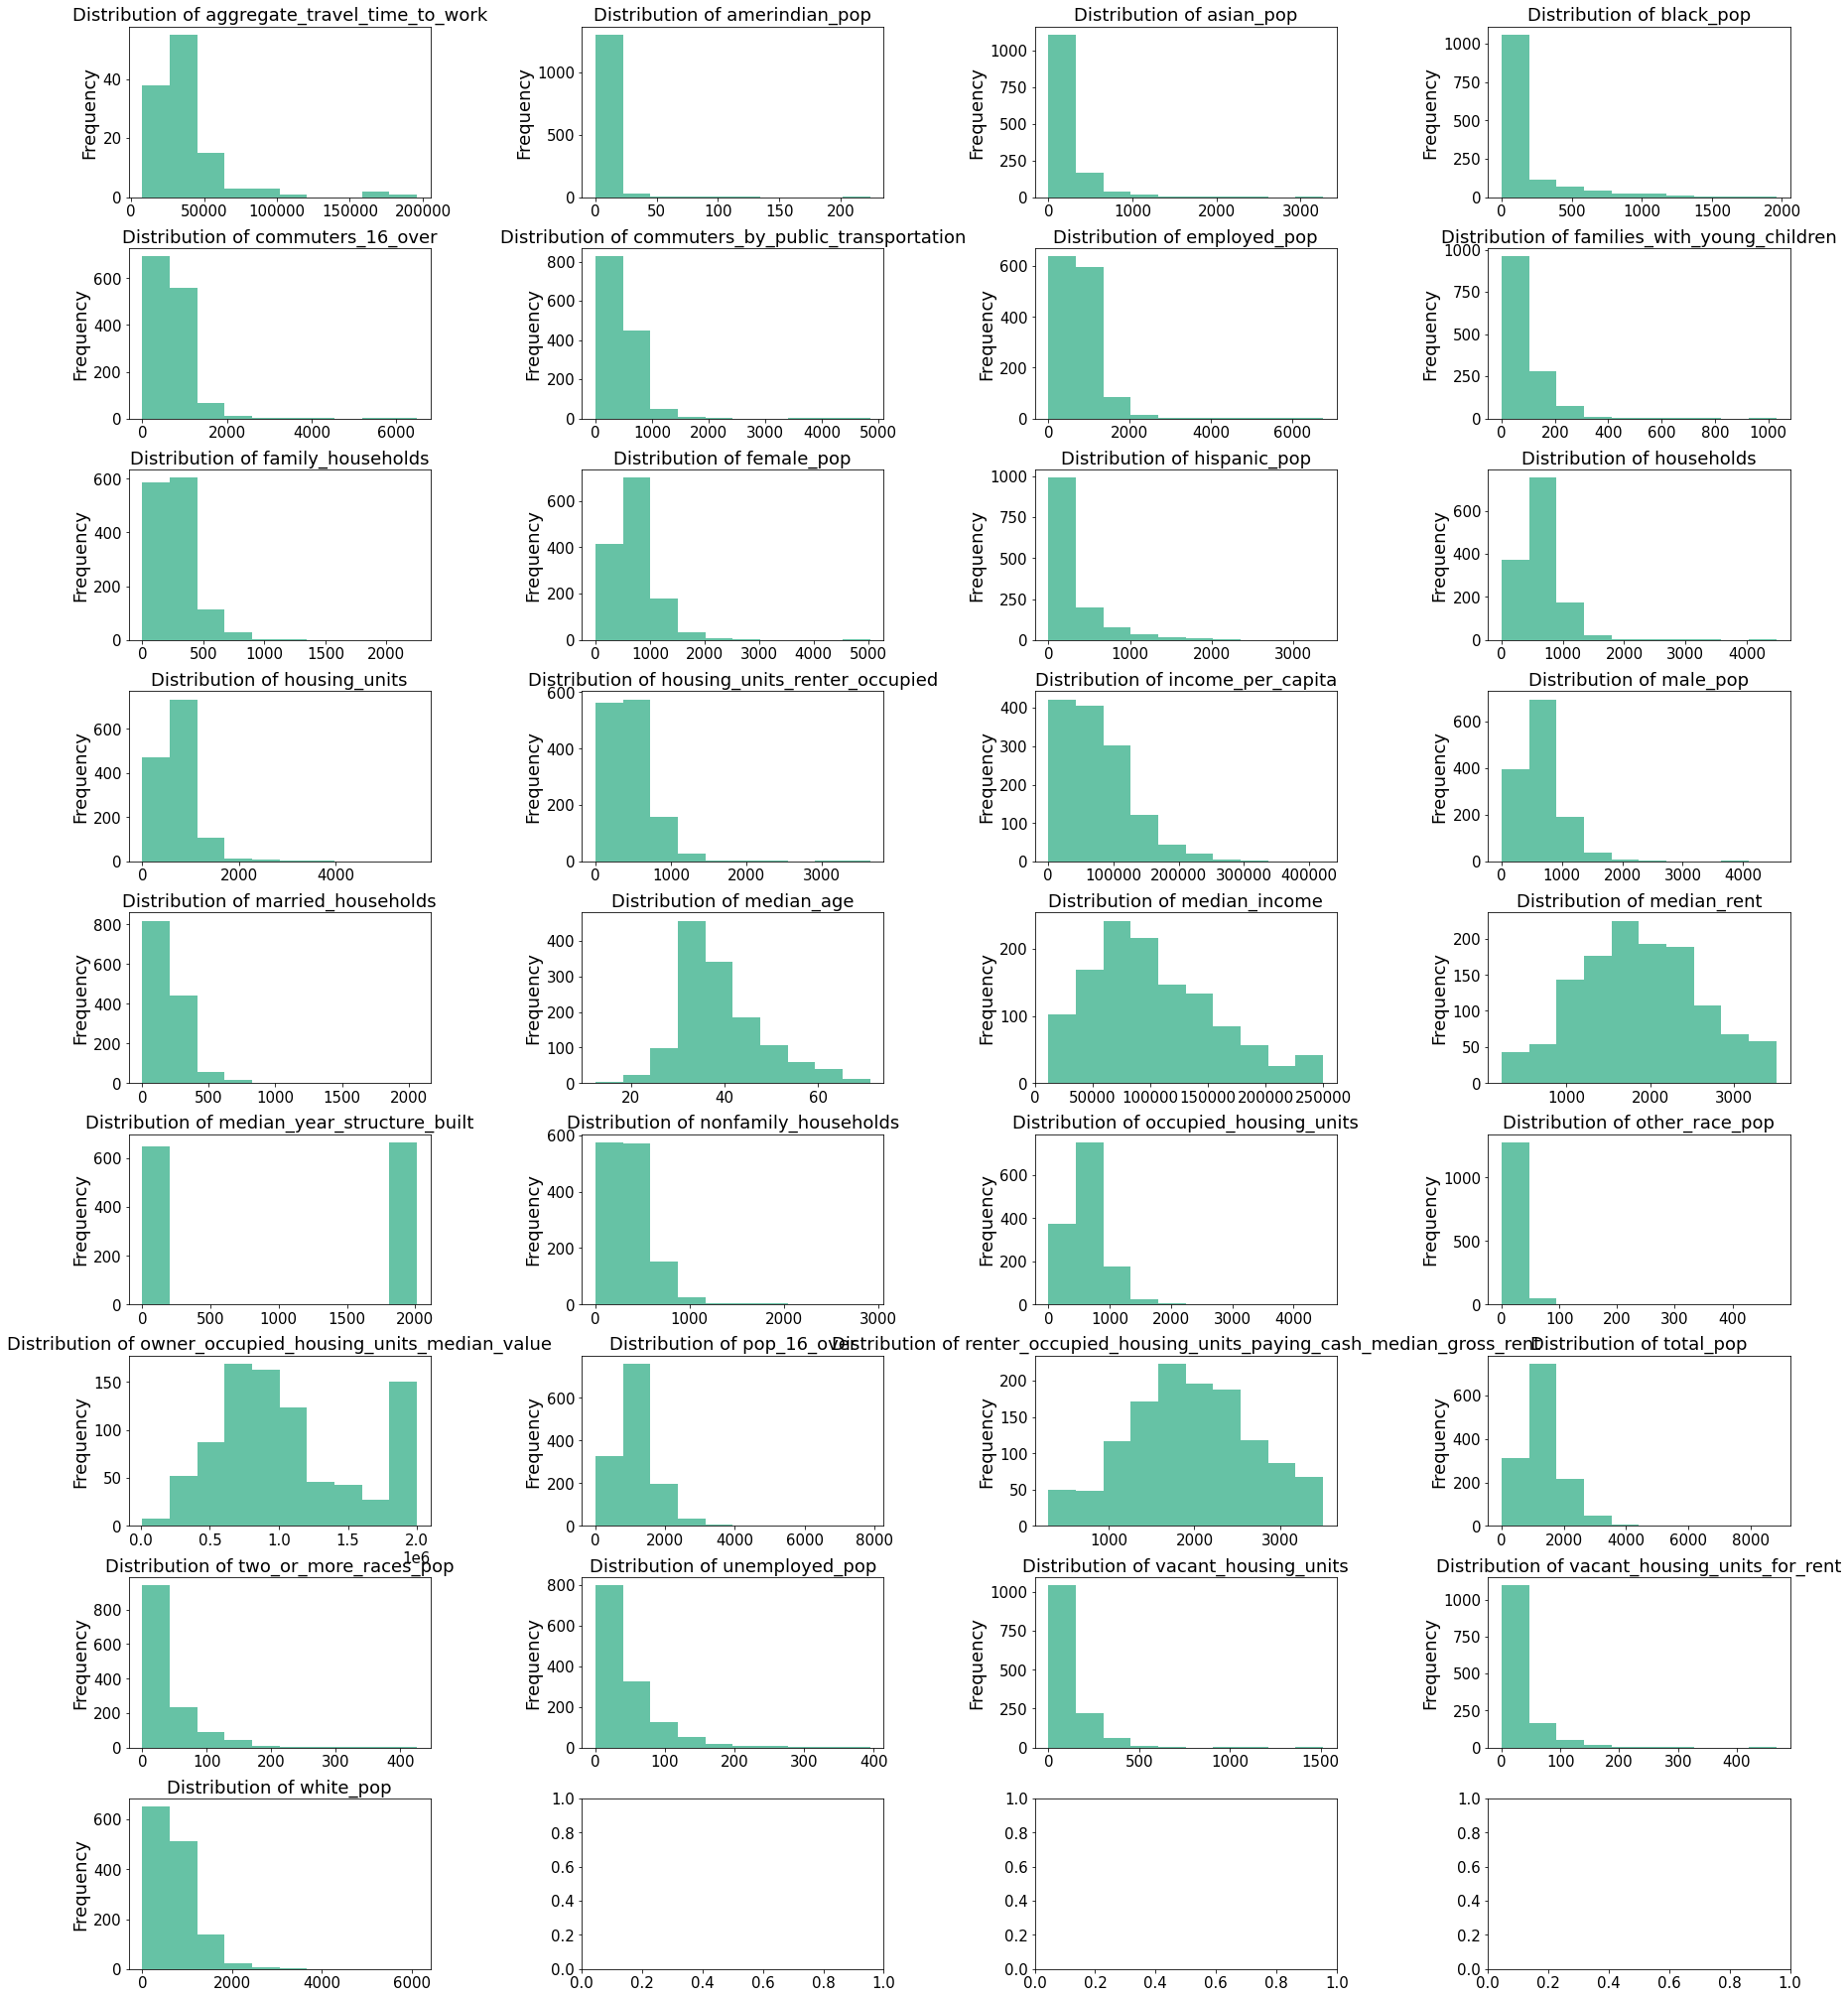

In [28]:
# Distribution of variables

cols_to_plot = [col for col in df.columns if col not in ['geoid', 'n_pickups']]

fig, ax = plt.subplots(9, 4, figsize=(30,36))
plt.subplots_adjust(hspace=.3, wspace=.5)
for i, variable in enumerate(cols_to_plot):
    a = df.plot('n_pickups',
                variable,
                kind='hist',
                ax=ax[int(i/4), (i%4)],
                legend=False)
    a.set_title(f'Distribution of {variable}')

plt.show()

# 2-2. Modeling


* Train a baseline model for the n_pickups using ACS variables as covariates.
* What is the performance of the model?
* What can we learn from this model?


Since the **target (n_pickup) is a continuous variable**, I'll use **linear regression** as a baseline model.

Columns from the demographic table will be used as features, n_pickups will be the target.

### Check linearity by using:
* Scatterplot of variables
* Correlation coefficient

In [29]:
# Set 'geoid' as index
df.set_index('geoid', inplace=True)

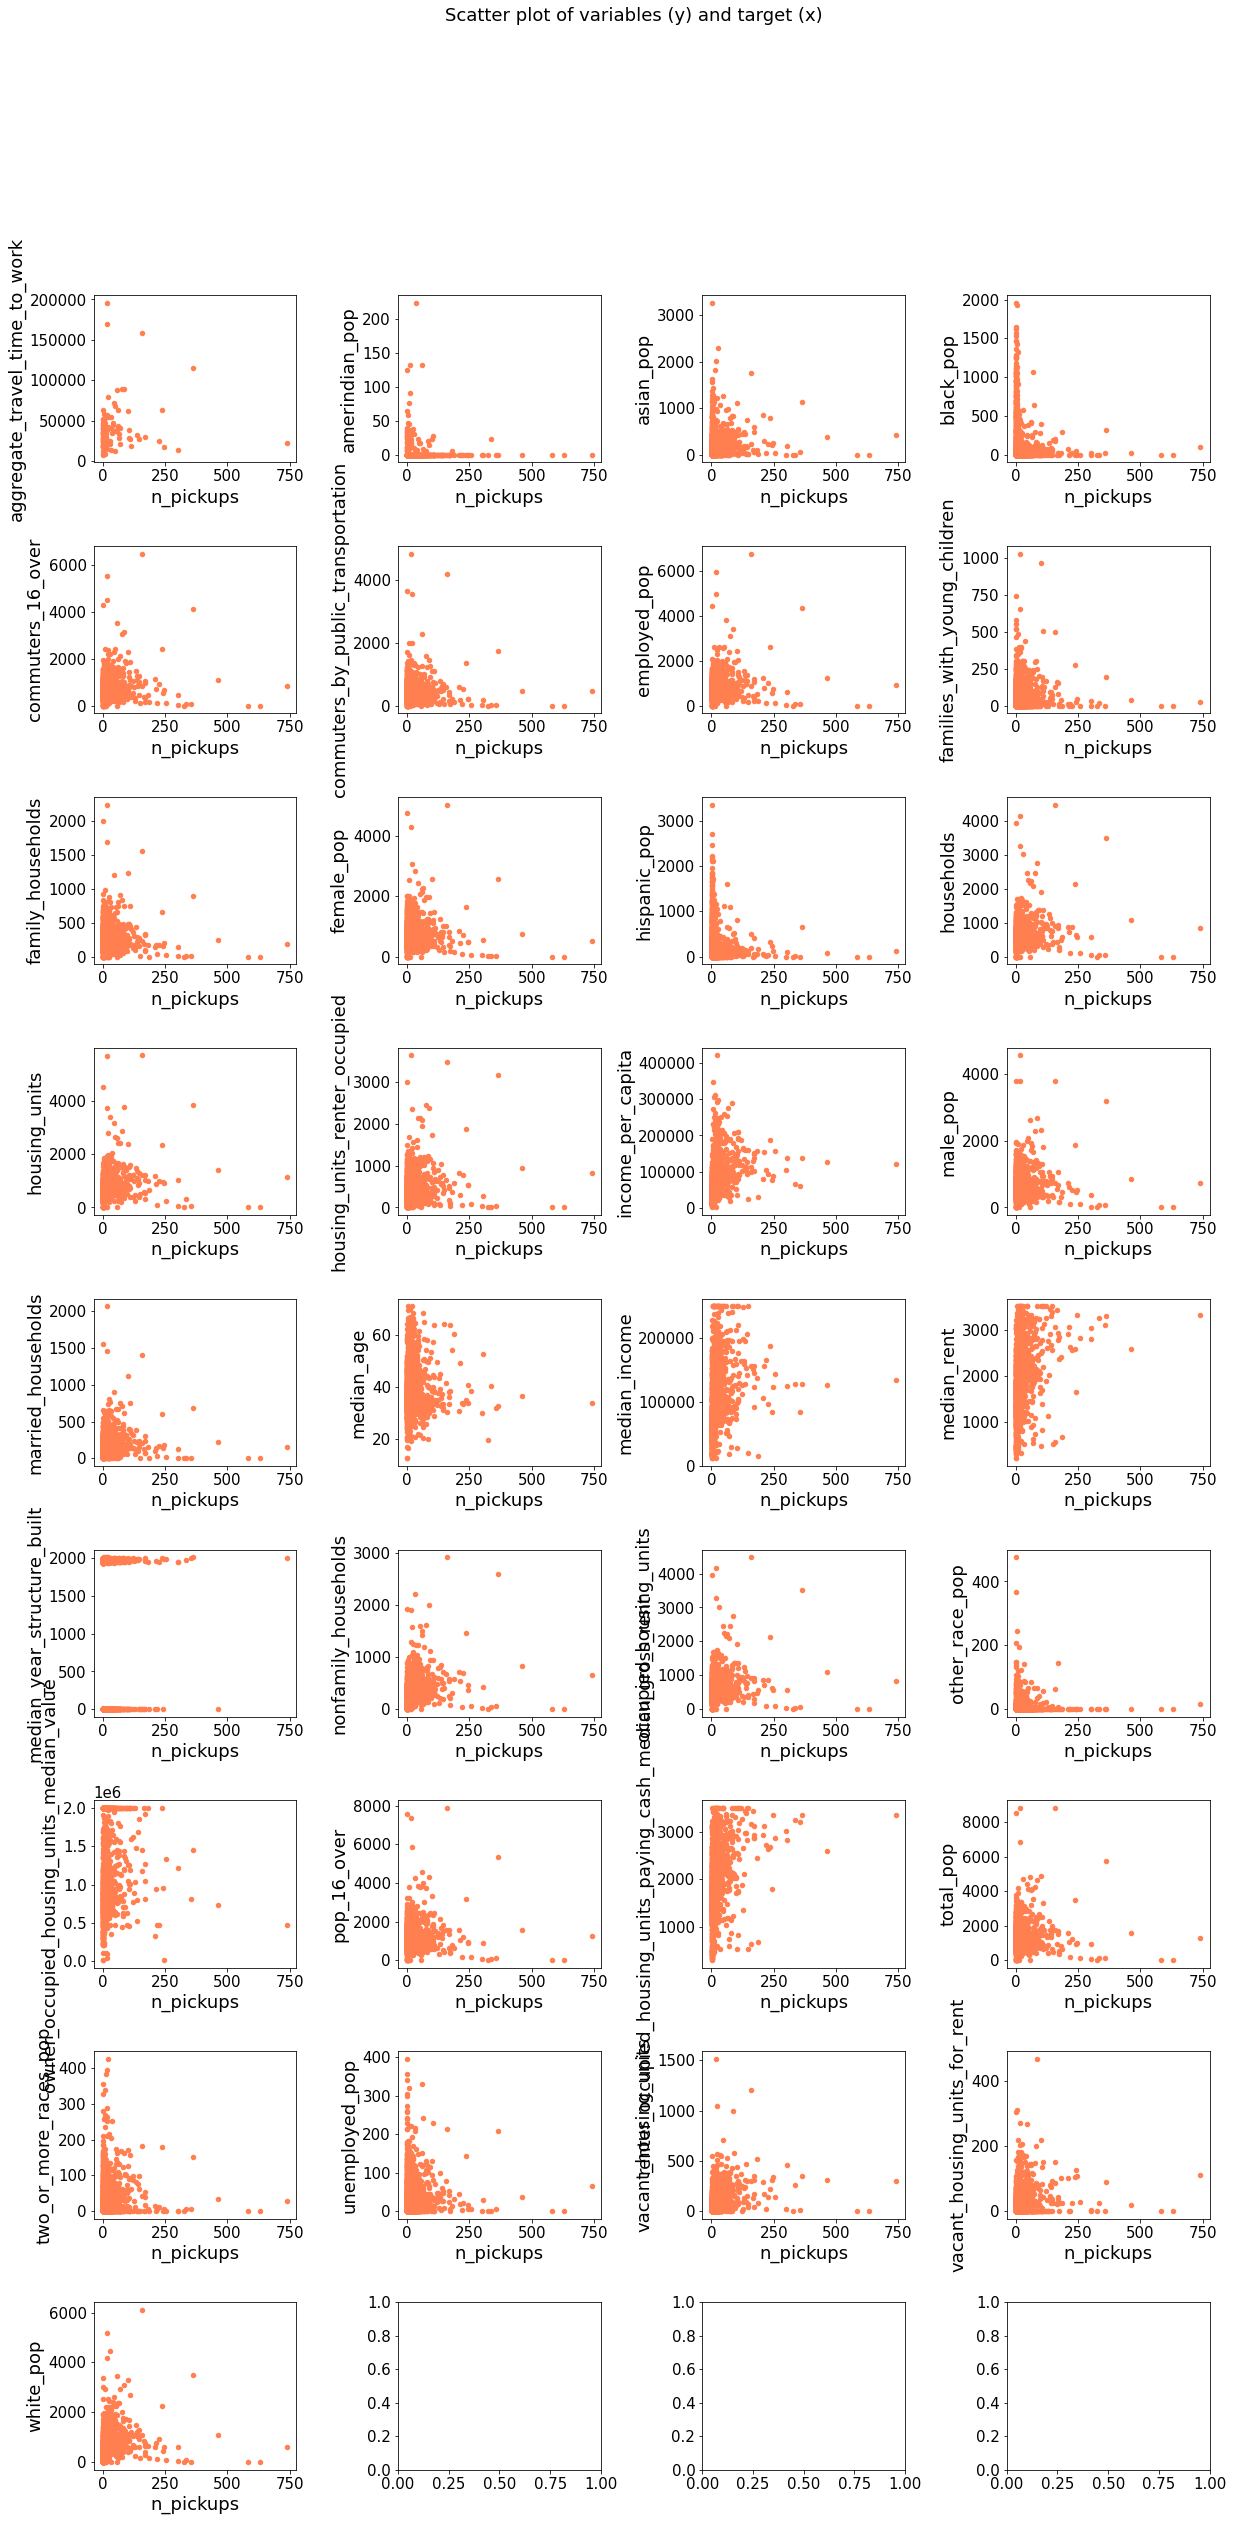

In [30]:
# Scatterplot of variables to check for linearity
fig, ax = plt.subplots(9, 4, figsize=(20,40))
plt.subplots_adjust(hspace=.5, wspace=.5)
plt.suptitle('Scatter plot of variables (y) and target (x)')

for i, variable in enumerate(cols_to_plot):
    df.plot('n_pickups',
            variable,
            kind='scatter',
            color='coral',
            ax=ax[int(i/4), (i%4)])

plt.show()

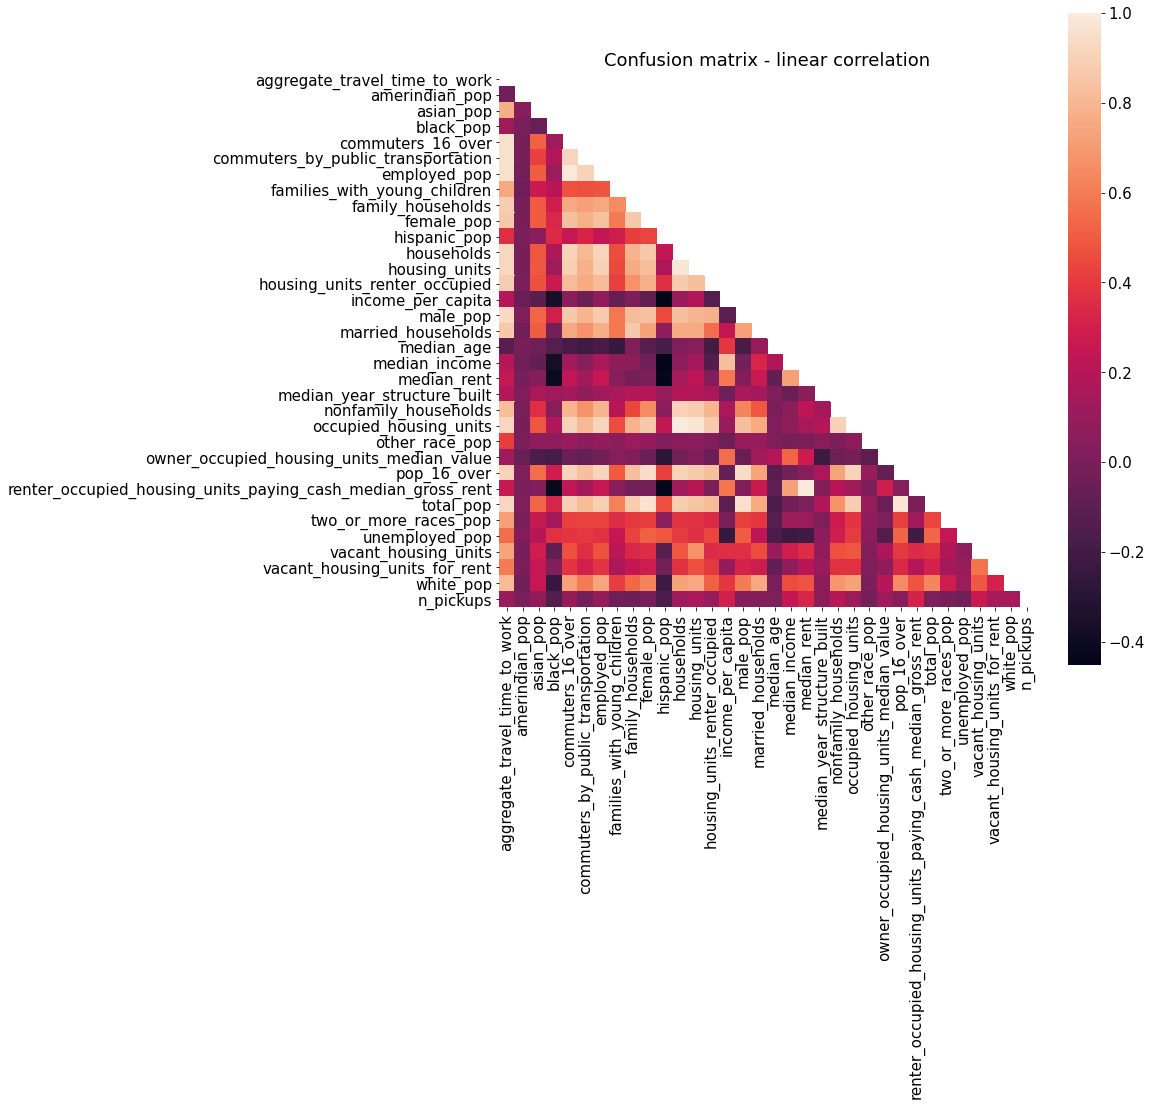

In [31]:
# Calculate correlation coefficient
corr = df.corr()

# Confusion matrix
plt.figure(figsize=(12,12))
matrix = np.triu(corr)
sns.heatmap(corr, fmt='.1g', square=True, mask=matrix)
plt.title('Confusion matrix - linear correlation')
plt.show()

### Feature selection

Based on the scatterplot and correlation coefficient, I will manually selected some features that looks like to have linear relationship with the target for our baseline model

In [32]:
# Select features relatively correlated (r > 0.09) with the target only
select_highly_correlated = abs(corr['n_pickups']) > 0.09
features = corr[select_highly_correlated]['n_pickups'].index
features = [feat for feat in features if feat != 'n_pickups']

In [33]:
# Are there any missing values within the selected features?
print(f'Is there any missing value?: {bool(df[features].isnull().any().sum())}')

Is there any missing value?: True


In [34]:
# Which features have missing rows and how many?
df[features].isnull().mean()

aggregate_travel_time_to_work                                  0.911940
black_pop                                                      0.000000
employed_pop                                                   0.000000
hispanic_pop                                                   0.000000
households                                                     0.000000
housing_units                                                  0.000000
housing_units_renter_occupied                                  0.000000
income_per_capita                                              0.011940
median_income                                                  0.090299
median_rent                                                    0.061940
nonfamily_households                                           0.000000
occupied_housing_units                                         0.000000
owner_occupied_housing_units_median_value                      0.352239
renter_occupied_housing_units_paying_cash_median_gross_rent    0

**Note**

* 'aggregate_travel_time_to_work' feature misses almost 90% of the data -> REMOVE
* Other features with missing values -> Let's try simple inputation

In [35]:
# 1. Remove 'aggregate_travel_time_to_work' column
print(len(features))
features = [feat for feat in features if feat != 'aggregate_travel_time_to_work']
print(len(features))

17
16


In [36]:
# Initiate SimpleImputer. Methods to inpute: most_frequent values
my_imputer = SimpleImputer(strategy='most_frequent')

# Redefine df using selected features and column.
columns = features + ['n_pickups']

# Impute missing values of the reduced df.
df = pd.DataFrame(my_imputer.fit_transform(df[columns]), columns=columns)

In [37]:
# Define target
target = 'n_pickups'

In [38]:
# Check if imputation worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   black_pop                                                    1340 non-null   float64
 1   employed_pop                                                 1340 non-null   float64
 2   hispanic_pop                                                 1340 non-null   float64
 3   households                                                   1340 non-null   float64
 4   housing_units                                                1340 non-null   float64
 5   housing_units_renter_occupied                                1340 non-null   float64
 6   income_per_capita                                            1340 non-null   float64
 7   median_income                                                1340 non-null   f

### Split the data into train & test set to measure model performance

In [39]:
# train_test split
X_train, X_test, y_train, y_test = train_test_split(df[features], # X
                                                    df[target],   # y
                                                    test_size=0.3,
                                                    shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(938, 16)
(402, 16)
(938,)
(402,)


### Fit a linear regression model using train data

In [40]:
# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Evaluate the model performance using test data

In [41]:
# Predict on test set
y_pred = lr.predict(X_test) # use the predict method of the object

In [42]:
# Evaluate the performance using RMSE
MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', round(MAE, 2))

Mean Absolute Error: 23.88


**Note**

The number of taxi pickups (target) was predicted by using a subset of ACS fields that has a certain degree of linear relationship with the target.

I chose MAE (Mean Absolute Error) as an evaluation metric since it is intuitively easy to understand how far out prediction is off from a true value. In the future, MSE (Mean Sqaured Error) can be also considered if the model requires higher penalization on wrong predictions far off the mark.

The MAE from current model is around 24, which means that our prediction on the number of taxi pickups within a census block can be wrong by 24 taxi trips in average. Therefore, its precision on the target prediction is quite low.

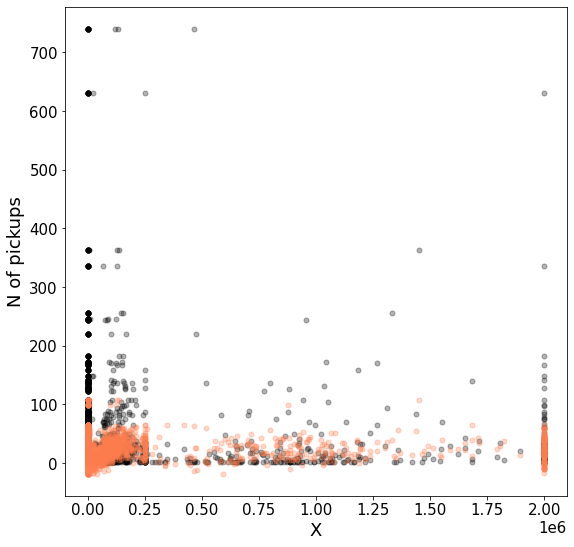

In [43]:
# Plot the true values (y_test) and predicted values (y_pred) together.
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(X_test, y_test, 'black', marker='o',
        markersize=5, alpha=.3, linewidth=0)
ax.plot(X_test, y_pred, 'coral', marker='o',
        markersize=5, alpha=.3, linewidth=0)

plt.xlabel('X')
plt.ylabel('N of pickups')
plt.show()

### Discussion - How can we improve the model performance?

First, we can improve the current features by using different data preprocessing methods such as outlier identification, missing value imputation, normalization or aggregation.

Second, we can add more additional features that might be strongly correlated to the target variable. One example would be adding calendar attributes of the pickup dates (month / week of month / weekday / hour) or area of each block. Another exmaple is to add more location information using open data source such as [New York City Borough Boundaries data](https://geo.nyu.edu/catalog/nyu-2451-34510) or Open Street Map's geodata that can be extracted with QGIS.

Finally, we can try different machine learning models such as Decision tree regressor or ensemble learning models like XGBoost.

# End of notebook